# Chapter 3. Data Analysis : Advanced Project in Digital Media Engineering

- previous chapter 1, about NOAA data ETL, can be redirected from the link __[here](http://nbviewer.jupyter.org/github/ShawnHouCHN/Advanced-Project-in-Digital-Media-Engineering-E17/blob/master/notebooks/USA%20climatological%20station%20data%20parser.ipynb)__ 

- previous chapter 2, about Twitter data ETL, can be redirected from the link __[here](http://nbviewer.jupyter.org/github/ShawnHouCHN/Advanced-Project-in-Digital-Media-Engineering-E17/blob/master/notebooks/USA%20twitter%20data%20parser.ipynb)__

***
In this chapter, the notebook will show the analysis of correlation between twitter and noaa data. Some visualizations have been made to give a intuitvie insights of the result. <br>
The author is Xiaoshen Hou s132732 from DTU

In [1]:
import numpy as np
from StringIO import StringIO
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt
import urllib2,base64
import cPickle as pickle
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
from __future__ import division
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import geoplotlib as gp
import scipy as sp
import pysal as ps
import datetime
import operator
import re
import os
import os.path
import requests, time
import urllib, json
import csv
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
tls.set_credentials_file(username='ShawnHou', api_key='OohmqCJaPfb6p6xo4pDF')
from geoplotlib.utils import BoundingBox
from sklearn import neighbors, datasets,linear_model,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from pylab import *
from scipy import stats
from sklearn.neighbors import DistanceMetric
from urllib2 import urlopen, Request
from pprint import pprint
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from collections import defaultdict
from operator import itemgetter
from pushover import init, Client
from scipy.spatial import KDTree
from scipy.signal import correlate
from calendar import monthrange
from statsmodels.tsa import stattools
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
%matplotlib inline

C:\WorkingGround\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



### Twitter Data Ingestion

#### 1. LOAD WEATHER KEYWORDS

In [2]:
js = open('data\\daily dataframe\\keyword_map.json').read()
weather_keywords = json.loads(js)
print weather_keywords.keys()

[u'scalding', u'flaming', u'humid', u'hypothermic', u'shivering', u'scorched', u'nippy', u'balmy', u'steamy', u'frigorific', u'antarctic', u'wintry', u'ice-cold', u'shivery', u'sweltry', u'broiling', u'scorching', u'summery', u'icy-cold', u'siberian', u'arid', u'sweaty', u'tropical', u'hot', u'sweat-inducing', u'sweltering', u'bleak', u'ovenlike', u'stifling', u'glacial', u'heat-wave', u'steaming-hot', u'boiling-hot', u'baking-hot', u'afire', u'blistering', u'algid', u'chilled to the bone', u'snowy', u'white-hot', u'heatwave', u'arctic', u'blazing-hot', u'rimy', u'chilled-through', u'stinging-cold', u'freezing', u'warm', u'gelid', u'smoking', u'blizzardy', u'icy', u'conflagrant', u'sizzling', u'frozen-over', u'muggy', u'sub-zero', u'chilled', u'bitterly-cold', u'smoking-hot', u'frozen', u'torrid', u'blazing', u'red-hot', u'chilly', u'bitter-cold', u'parky', u'parching', u'numbing', u'numbing-cold', u'calescent', u'shiver-inducing', u'sultry', u'frosty']


In [3]:
date_rng=[d.strftime('%Y%m%d') for d in pd.date_range('2016-1-1', periods=366, freq='D')] #range from 2016-1-1 to 12-31
columns=date_rng.append('FIPS')
county_avg_knn_df=pd.read_csv('data\\daily dataframe\\county_values_knn.csv', dtype={'FIPS':'object'},names=columns)
raw_county_hot_df=pd.read_csv('data\\daily dataframe\\county_values_hot.csv', dtype={'FIPS':'object'},names=columns)
raw_county_cold_df=pd.read_csv('data\\daily dataframe\\county_values_cold.csv', dtype={'FIPS':'object'},names=columns)
usa_counties_df = pd.read_csv(os.getcwd()+'\\data\\daily dataframe\\county_meta.csv',skipinitialspace=True)
usa_counties_df['FIPS'] = usa_counties_df['FIPS'].apply(lambda x: format(x, '05d'))
usa_counties_df['Latitude']  = [ float(x.decode("utf-8", "ignore")[1:-1]) for x in usa_counties_df['Latitude'].values]
usa_counties_df['Longitude']  = [ -float(x.decode("utf-8", "ignore")[1:-1]) for x in usa_counties_df['Longitude'].values]
#usa_counties_df['Latitude'] = usa_counties_df['Latitude'].apply(lambda x: float(x.decode("utf-8", "ignore")[1:-1]))
#usa_counties_df['Longitude'] = usa_counties_df['Latitude'].apply(lambda x: -float(x.decode("utf-8", "ignore")[1:-1]))

#### First of all, Get rid of outliers

In [4]:
county_cold_ids_list=raw_county_cold_df['FIPS']
county_hot_ids_list=raw_county_hot_df['FIPS']
filtered_cold_data=list()
filtered_hot_data=list()
#for index, row in raw_county_cold_df.iloc[:, :-1].iterrows():
    #print row.median()
#    row[(row > (row.std() * 3))] = row.quantile(0.75)
#    row[(row < -(row.std() * 3))] = row.quantile(0.25)
#    filtered_cold_data.append(row.tolist())

    
#for index, row in raw_county_hot_df.iloc[:, :-1].iterrows():
    #print row.median()
#    row[(row > (row.std() * 3))] = row.quantile(0.75)
#    row[(row < -(row.std() * 3))] = row.quantile(0.25)
#    filtered_hot_data.append(row.tolist())    

#county_cold_df=pd.DataFrame(data=np.array(filtered_cold_data), columns=raw_county_cold_df.iloc[:, :-1].columns)
#county_cold_df['FIPS']=county_cold_ids_list
#county_hot_df=pd.DataFrame(data=np.array(filtered_hot_data), columns=raw_county_hot_df.iloc[:, :-1].columns)
#county_hot_df['FIPS']=county_hot_ids_list
county_cold_df=raw_county_cold_df
county_hot_df=raw_county_hot_df


#### Second. Compute the sum variable to hot&cold count

In [5]:
combed_cold_data=list()
combed_hot_data=list()
county_comb_ids_list=county_cold_df['FIPS']
for index, row in county_cold_df.iloc[:, :-1].iterrows():
    #print row.median()
    a_county=np.array(row.tolist())
    a_county=a_county-np.min(a_county)
    if np.max(a_county)!=0:
        a_county=a_county/np.max(a_county) 
    combed_cold_data.append(a_county)
    
    
for index, row in county_hot_df.iloc[:, :-1].iterrows():
    #print row.median()
    a_county=np.array(row.tolist())
    a_county=a_county-np.min(a_county)
    if np.max(a_county)!=0:
        a_county=a_county/np.max(a_county)
    combed_hot_data.append(a_county)

combed_hot_cold_data=list()
for county_cold, county_hot in zip(combed_cold_data,combed_hot_data):
    county_comb=np.subtract(county_hot,county_cold)
    combed_hot_cold_data.append(county_comb)

county_comb_df=pd.DataFrame(data=np.array(combed_hot_cold_data), columns=raw_county_cold_df.iloc[:, :-1].columns)
county_comb_df['FIPS']=county_comb_ids_list


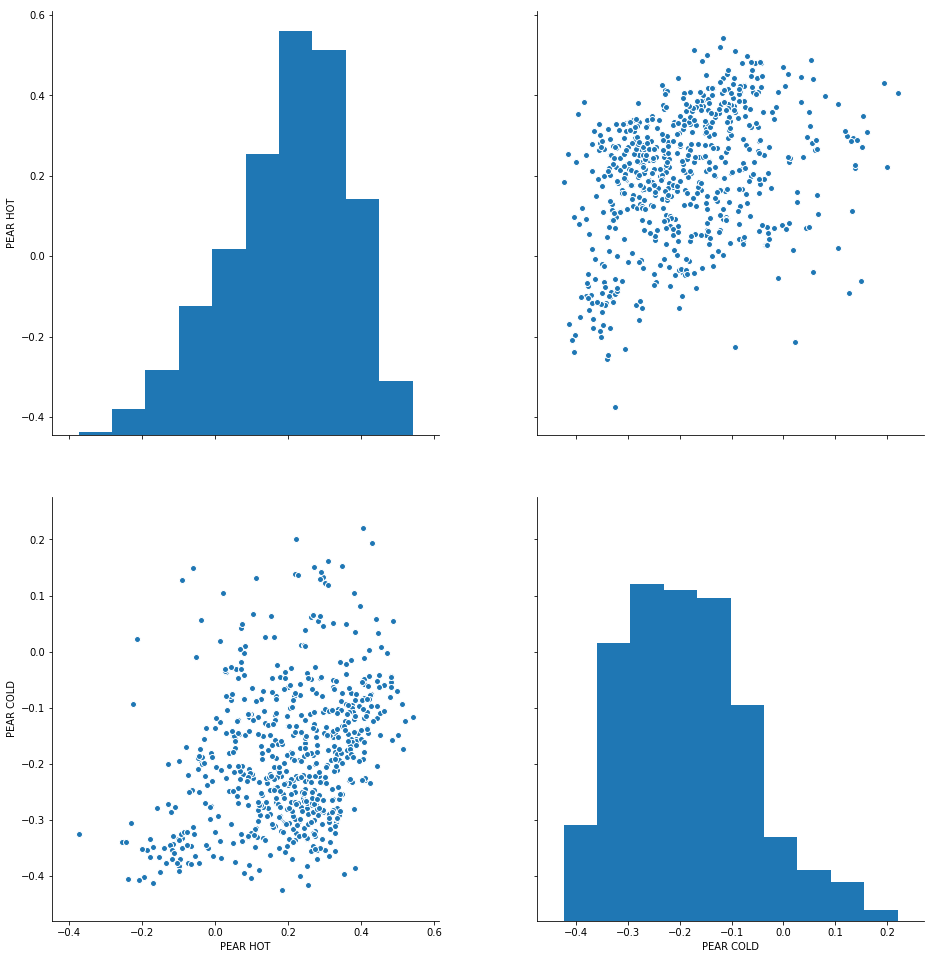

In [6]:
# Get the top 20% county with most of tweets in total (HOT + COLD)
county_cold_nolabel_df = county_cold_df.drop(county_cold_df.columns[-1],axis=1)
county_hot_nolabel_df = county_hot_df.drop(county_hot_df.columns[-1],axis=1)

df_add=county_cold_nolabel_df.add(county_hot_nolabel_df)
df_add['FIPS']=county_avg_knn_df['FIPS'].tolist()
df_add.set_index(['FIPS'])
df_add['TOTAL']=df_add.sum(axis=1)
toprate=0.2
amount=int(round(len(df_add.index)*0.2))
df_top=df_add.nlargest(amount, 'TOTAL')


top_counties_list=df_top['FIPS'].tolist()

county_hot_top_df=county_hot_df[county_hot_df['FIPS'].isin(top_counties_list)]
county_cold_top_df=county_cold_df[county_cold_df['FIPS'].isin(top_counties_list)]
county_tmax_top_df=county_avg_knn_df[county_avg_knn_df['FIPS'].isin(top_counties_list)]
county_comb_top_df = county_comb_df[county_comb_df['FIPS'].isin(top_counties_list)]

pear_hot_top_list=list()
pear_cold_top_list=list()
for index, row in county_hot_top_df.iterrows():
    county_tmaxs = county_avg_knn_df[county_avg_knn_df['FIPS']==row.tolist()[-1]].values.tolist()[0][:-1]
    pear_hot=sp.stats.pearsonr(county_tmaxs,row.tolist()[:-1])[0]
    pear_hot_top_list.append(pear_hot)
for index, row in county_cold_top_df.iterrows():
    county_tmaxs = county_avg_knn_df[county_avg_knn_df['FIPS']==row.tolist()[-1]].values.tolist()[0][:-1]
    pear_cold=sp.stats.pearsonr(county_tmaxs,row.tolist()[:-1])[0]
    pear_cold_top_list.append(pear_cold)
    
correlation_top_df = pd.DataFrame({'PEAR HOT':pear_hot_top_list, 'PEAR COLD':pear_cold_top_list,'FIPS':county_hot_top_df['FIPS'].tolist()})

county_name_top_list=list()
for index, row in county_hot_top_df.iterrows():
    county_name=usa_counties_df.loc[usa_counties_df['FIPS'] == row.tolist()[-1] , 'County [2]'].iloc[0]
    county_name_top_list.append(county_name)

correlation_top_df['NAME']=county_name_top_list


pair_corr=sns.pairplot(correlation_top_df,vars=['PEAR HOT','PEAR COLD'])
pair_corr.fig.set_size_inches(15,15, forward=True)

#### if the daily RELATIVE temp is computed with a rolling window of 30 days

In [7]:
rolling_window_size=30
top_counties_serie=county_hot_top_df['FIPS']
county_tmax_top_ori_df = county_avg_knn_df[county_avg_knn_df['FIPS'].isin(top_counties_list)].drop(county_avg_knn_df.columns[-1],axis=1)
county_tmax_top_smoo_df = county_avg_knn_df[county_avg_knn_df['FIPS'].isin(top_counties_list)].drop(county_avg_knn_df.columns[-1],axis=1).rolling(window=rolling_window_size,min_periods=1,center=True,axis=1).mean()
county_tmax_top_diff_df = county_tmax_top_ori_df.subtract(county_tmax_top_smoo_df)
county_tmax_top_diff_df['FIPS'] = top_counties_serie
county_tmax_top_smoo_df['FIPS'] = top_counties_serie
print "The Rolling-Meaned Sample Data "

The Rolling-Meaned Sample Data 


In [8]:
pear_hot_diff_top_list=list()
pear_cold_diff_top_list=list()
for index, row in county_hot_top_df.iterrows():
    county_tmaxs = county_tmax_top_diff_df[county_tmax_top_diff_df['FIPS']==row.tolist()[-1]].values.tolist()[0][:-1]
    pear_hot=sp.stats.pearsonr(county_tmaxs,row.tolist()[:-1])[0]
    pear_hot_diff_top_list.append(pear_hot)
for index, row in county_cold_top_df.iterrows():
    county_tmaxs = county_tmax_top_diff_df[county_tmax_top_diff_df['FIPS']==row.tolist()[-1]].values.tolist()[0][:-1]
    pear_cold=sp.stats.pearsonr(county_tmaxs,row.tolist()[:-1])[0]
    pear_cold_diff_top_list.append(pear_cold)
    
correlation_diff_top_df = pd.DataFrame({'PEAR HOT':pear_hot_top_list, 'PEAR COLD':pear_cold_top_list,'FIPS':county_hot_top_df['FIPS'].tolist()})

county_name_top_list=list()
for index, row in county_hot_top_df.iterrows():
    county_name=usa_counties_df.loc[usa_counties_df['FIPS'] == row.tolist()[-1] , 'County [2]'].iloc[0]
    county_name_top_list.append(county_name)

correlation_diff_top_df['NAME']=county_name_top_list


####TEST
pear_comb_top_list=list()
pear_comb_diff_top_list=list()
for index, row in county_comb_top_df.iterrows():
    county_tmaxs = county_avg_knn_df[county_avg_knn_df['FIPS']==row.tolist()[-1]].values.tolist()[0][:-1]
    county_tmaxs_diff = county_tmax_top_diff_df[county_tmax_top_diff_df['FIPS']==row.tolist()[-1]].values.tolist()[0][:-1]
    pear_comb=sp.stats.pearsonr(county_tmaxs,row.tolist()[:-1])[0]
    pear_diff_comb=sp.stats.pearsonr(county_tmaxs_diff,row.tolist()[:-1])[0]
    pear_comb_top_list.append(pear_comb)
    pear_comb_diff_top_list.append(pear_diff_comb)

In [9]:
county_hot_top_df['NAME']=county_name_top_list
county_cold_top_df['NAME']=county_name_top_list
county_tmax_top_diff_df['NAME']=county_name_top_list

C:\WorkingGround\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\WorkingGround\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



#### 1. Pearson Correlation Distribution of unsmoothed, smoothed data

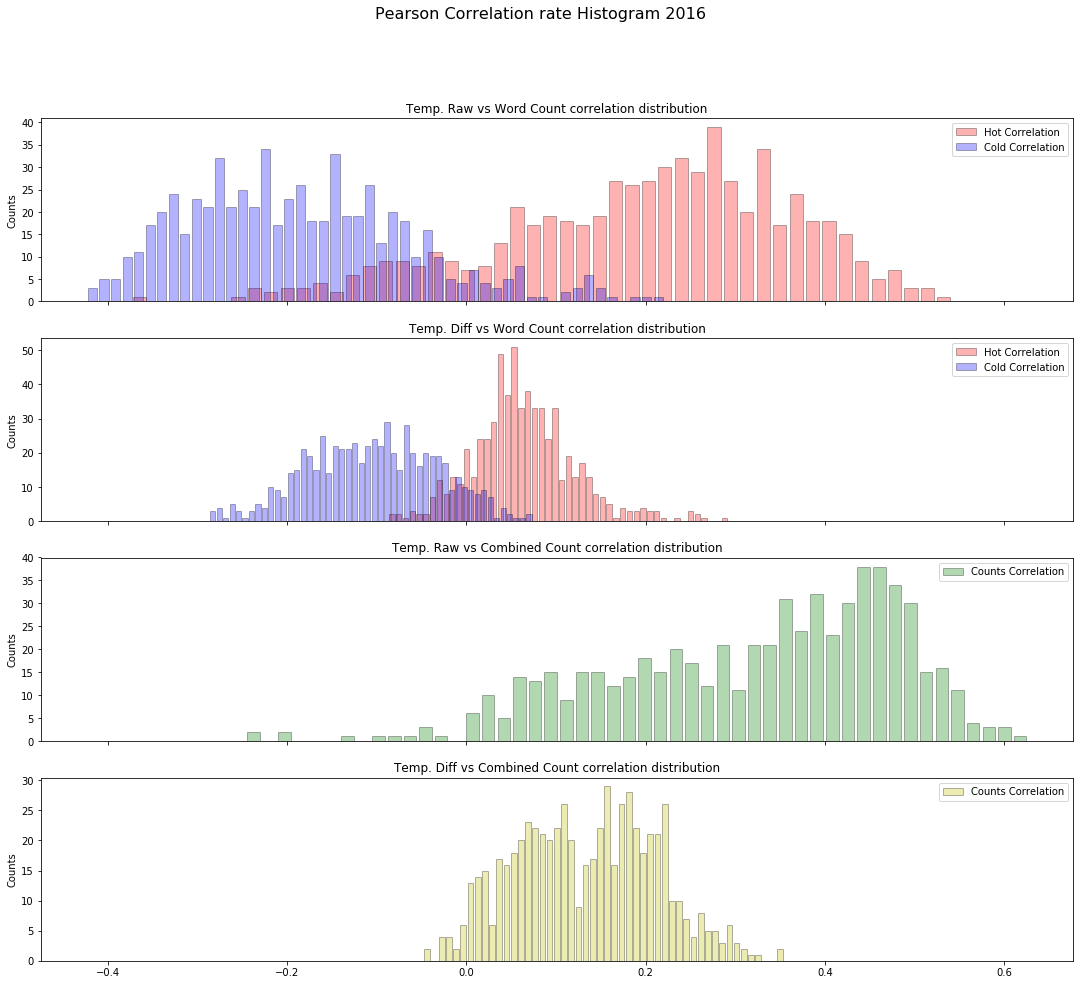

In [10]:
f, axarr = plt.subplots(4, sharex=True)
f.suptitle('Pearson Correlation rate Histogram 2016', fontsize=16)
f.set_size_inches(18.5, 15.5, forward=True)
axarr[0].hist(pear_hot_top_list, bins=50,alpha=0.3, histtype='bar', ec='black',rwidth=0.8, label='Hot Correlation',color='r')
axarr[0].hist(pear_cold_top_list, bins=50,alpha=0.3, histtype='bar', ec='black',rwidth=0.8, label='Cold Correlation', color='b')
axarr[0].legend()
axarr[0].set_ylabel('Counts')
axarr[0].set_title('Temp. Raw vs Word Count correlation distribution')

axarr[1].hist(pear_hot_diff_top_list, bins=50,alpha=0.3, histtype='bar', ec='black',rwidth=0.8, label='Hot Correlation',color='r')
axarr[1].hist(pear_cold_diff_top_list, bins=50,alpha=0.3, histtype='bar', ec='black',rwidth=0.8, label='Cold Correlation', color='b')
axarr[1].legend()
axarr[1].set_ylabel('Counts')
axarr[1].set_title('Temp. Diff vs Word Count correlation distribution')

axarr[2].hist(pear_comb_top_list, bins=50,alpha=0.3, histtype='bar', ec='black',rwidth=0.8, label='Counts Correlation',color='g')
axarr[2].legend()
axarr[2].set_ylabel('Counts')
axarr[2].set_title('Temp. Raw vs Combined Count correlation distribution')

axarr[3].hist(pear_comb_diff_top_list, bins=50,alpha=0.3, histtype='bar', ec='black',rwidth=0.8, label='Counts Correlation',color='y')
axarr[3].legend()
axarr[3].set_ylabel('Counts')
axarr[3].set_title('Temp. Diff vs Combined Count correlation distribution')


In [11]:
pear_comb_list=list()
for index, row in county_comb_df.iterrows():
    county_tmaxs = county_avg_knn_df[county_avg_knn_df['FIPS']==row.tolist()[-1]].values.tolist()[0][:-1]
    pear_comb=sp.stats.pearsonr(county_tmaxs,row.tolist()[:-1])[0]
    pear_comb_list.append(pear_comb)

county_comb_correlation_df = pd.DataFrame({'PEAR COMB':pear_comb_list})
county_all_list=county_avg_knn_df['FIPS'].tolist()
county_all_int_list = map(int, county_all_list)
county_comb_correlation_df['FIPS']=county_all_int_list
topo_path = r'data/daily dataframe/us-10m.json'

#with open(topo_path, 'r') as f:
#    get_id = json.load(f)

#print get_id['objects']['counties']['geometries']
correlate_map = folium.Map(location=[39.8282, -98.5795], zoom_start=4)
correlate_map.choropleth(topo_path, data=county_comb_correlation_df,columns=['FIPS','PEAR COMB'],topojson='objects.counties',
                         key_on='feature.id',
                         fill_color='OrRd',
                         line_weight=0.1, fill_opacity=0.7)


print "Correlation rate between TMAX and Combo counts in each county in period of 2016"
correlate_map.save('corr_map.html')
correlate_map

C:\WorkingGround\Anaconda\lib\site-packages\scipy\stats\stats.py:3021: RuntimeWarning:

invalid value encountered in double_scalars

C:\WorkingGround\Anaconda\lib\site-packages\scipy\stats\stats.py:3030: RuntimeWarning:

invalid value encountered in double_scalars

C:\WorkingGround\Anaconda\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning:

invalid value encountered in less



Correlation rate between TMAX and Combo counts in each county in period of 2016


In [12]:
county_comb_df.to_csv('county_values_comb.csv',index=False,encoding="UTF-8")

In [13]:
##Save the df into a json datafile for webgl template
county_comb_correlation_df['Latitude']=usa_counties_df['Latitude'].astype(int)
county_comb_correlation_df['Longitude']=usa_counties_df['Longitude'].astype(int)
county_comb_correlation_df=county_comb_correlation_df[['Latitude','Longitude','PEAR COMB','FIPS']]
global_plot_df = county_comb_correlation_df[['Latitude','Longitude','PEAR COMB']]
global_plot_df['PEAR COMB']=global_plot_df['PEAR COMB'].values ##amplify data
flatten_value_list=global_plot_df[['Latitude','Longitude','PEAR COMB']].values.flatten()
#type(flatten_value_list[0])
data = [['2016', np.nan_to_num(flatten_value_list).tolist()]]
with open('globe_data.json', 'w') as outfile:
    json.dump(data, outfile)

C:\WorkingGround\Anaconda\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [39]:
county_tmax_ori_df = county_avg_knn_df.drop(county_avg_knn_df.columns[-1],axis=1)
county_tmax_smoo_df = county_avg_knn_df.drop(county_avg_knn_df.columns[-1],axis=1).rolling(window=rolling_window_size,min_periods=1,center=True,axis=1).mean()
county_tmax_diff_df = county_tmax_ori_df.subtract(county_tmax_smoo_df)
county_tmax_diff_df['FIPS']=county_avg_knn_df['FIPS']
pear_comb_diff_list=list()
for index, row in county_comb_df.iterrows():
    county_tmaxs_diff = county_tmax_diff_df[county_tmax_diff_df['FIPS']==row.tolist()[-1]].values.tolist()[0][:-1]
    pear_diff_comb=sp.stats.pearsonr(county_tmaxs_diff,row.tolist()[:-1])[0]
    pear_comb_diff_list.append(pear_diff_comb)
    
    
county_comb_correlation_df['PEAR COMB DIFF']=pear_comb_diff_list

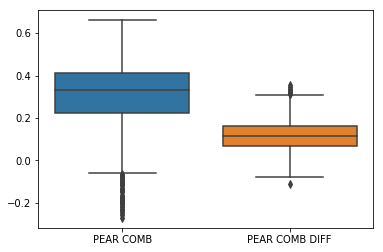

In [47]:
sns.boxplot(data=county_comb_correlation_df[['PEAR COMB','PEAR COMB DIFF']])

In [52]:
county_comb_correlation_df[['PEAR COMB','PEAR COMB DIFF']].describe().iloc[1:]

,PEAR COMB,PEAR COMB DIFF
mean,0.312331,0.116956
std,0.141909,0.068238
min,-0.270716,-0.110798
25%,0.224994,0.066256
50%,0.330330,0.114210
75%,0.413864,0.164023
max,0.660555,0.353581


#### Line charts of 4 sample cities, LA, MIl, Chi, Phe
1. Not standardized

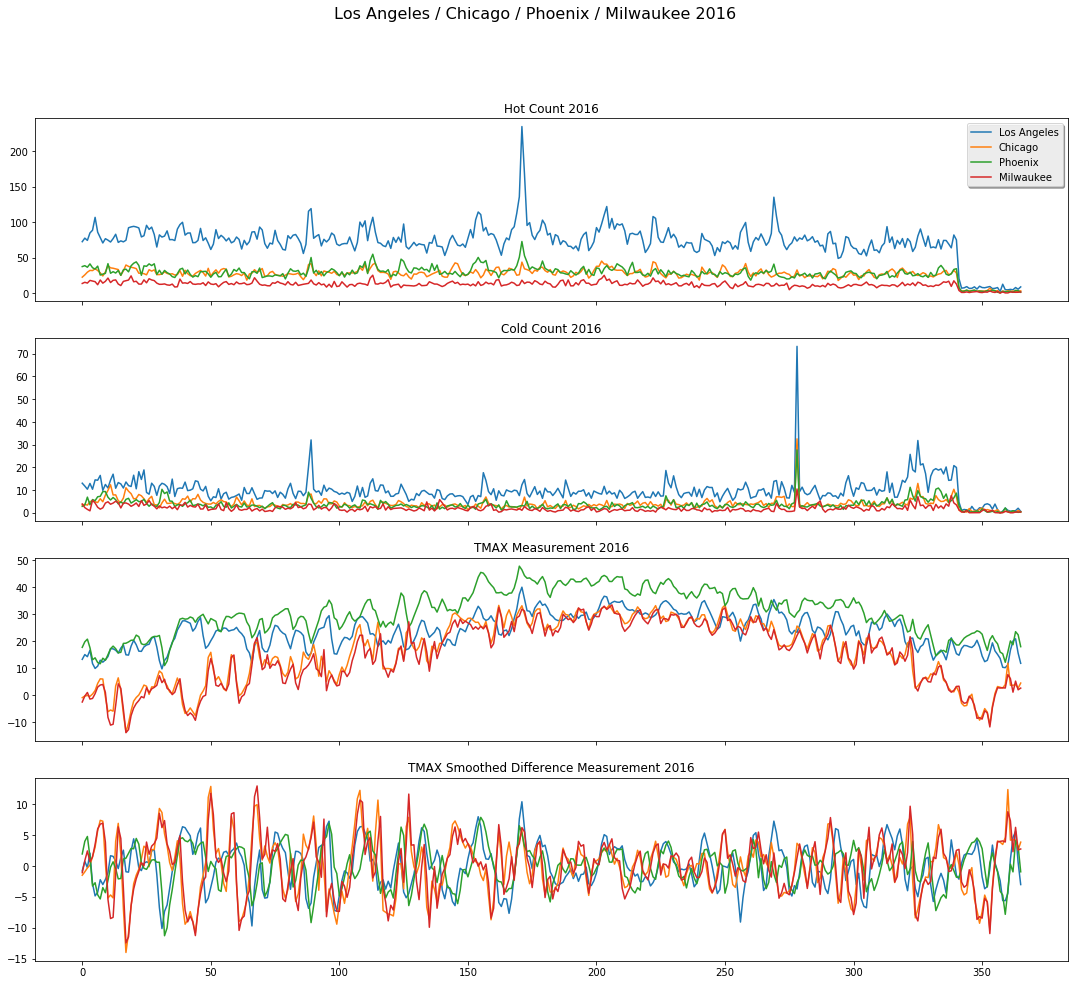

In [22]:
sample_cities_dict=defaultdict(dict)

fips_la="06037"  #06037 is Los Angeles
la_hot_list=county_hot_top_df.loc[county_hot_top_df.FIPS == fips_la].values.tolist()[0][:-2]
la_cold_list=county_cold_top_df.loc[county_cold_top_df.FIPS == fips_la].values.tolist()[0][:-2]
la_tmax_list = county_avg_knn_df.loc[county_avg_knn_df.FIPS ==fips_la].values.tolist()[0][:-1]
la_tmax_diff_list= county_tmax_top_diff_df.loc[county_tmax_top_diff_df.FIPS ==fips_la].values.tolist()[0][:-2]
la_comb_list= county_comb_df.loc[county_comb_df.FIPS ==fips_la].values.tolist()[0][:-1]

x_ticks=county_hot_top_df.columns.tolist()[:-2]
x = np.arange(len(la_tmax_list))

fips_chi="17031" #17031 is Chicago
chi_hot_list=county_hot_top_df.loc[county_hot_top_df.FIPS == fips_chi].values.tolist()[0][:-2]
chi_cold_list=county_cold_top_df.loc[county_cold_top_df.FIPS == fips_chi].values.tolist()[0][:-2]
chi_tmax_list = county_avg_knn_df.loc[county_avg_knn_df.FIPS ==fips_chi].values.tolist()[0][:-1]
chi_tmax_diff_list= county_tmax_top_diff_df.loc[county_tmax_top_diff_df.FIPS ==fips_chi].values.tolist()[0][:-2]
chi_comb_list= county_comb_df.loc[county_comb_df.FIPS ==fips_chi].values.tolist()[0][:-1]

fips_phi="04013" #04013 is Phoenix
phi_hot_list=county_hot_top_df.loc[county_hot_top_df.FIPS == fips_phi].values.tolist()[0][:-2]
phi_cold_list=county_cold_top_df.loc[county_cold_top_df.FIPS == fips_phi].values.tolist()[0][:-2]
phi_tmax_list = county_avg_knn_df.loc[county_avg_knn_df.FIPS ==fips_phi].values.tolist()[0][:-1]
phi_tmax_diff_list= county_tmax_top_diff_df.loc[county_tmax_top_diff_df.FIPS ==fips_phi].values.tolist()[0][:-2]
phi_comb_list= county_comb_df.loc[county_comb_df.FIPS ==fips_phi].values.tolist()[0][:-1]

fips_mil="55079" #55079 is Millwoukee
mil_hot_list=county_hot_top_df.loc[county_hot_top_df.FIPS == fips_mil].values.tolist()[0][:-2]
mil_cold_list=county_cold_top_df.loc[county_cold_top_df.FIPS == fips_mil].values.tolist()[0][:-2]
mil_tmax_list = county_avg_knn_df.loc[county_avg_knn_df.FIPS ==fips_mil].values.tolist()[0][:-1]
mil_tmax_diff_list= county_tmax_top_diff_df.loc[county_tmax_top_diff_df.FIPS ==fips_mil].values.tolist()[0][:-2]
mil_comb_list= county_comb_df.loc[county_comb_df.FIPS ==fips_mil].values.tolist()[0][:-1]

mil_tmax_list=np.array(mil_tmax_list)/10
phi_tmax_list=np.array(phi_tmax_list)/10
chi_tmax_list=np.array(chi_tmax_list)/10
la_tmax_list=np.array(la_tmax_list)/10

mil_tmax_diff_list=np.array(mil_tmax_diff_list)/10
phi_tmax_diff_list=np.array(phi_tmax_diff_list)/10
chi_tmax_diff_list=np.array(chi_tmax_diff_list)/10
la_tmax_diff_list=np.array(la_tmax_diff_list)/10

sample_cities_dict['Los Angeles']['HOT']=la_hot_list
sample_cities_dict['Los Angeles']['COLD']=la_cold_list
sample_cities_dict['Los Angeles']['TMAX']=la_tmax_list
sample_cities_dict['Los Angeles']['TMAX DIFF']=la_tmax_diff_list
sample_cities_dict['Los Angeles']['COMB']=la_comb_list
sample_cities_dict['Chicago']['HOT']=chi_hot_list
sample_cities_dict['Chicago']['COLD']=chi_cold_list
sample_cities_dict['Chicago']['TMAX']=chi_tmax_list
sample_cities_dict['Chicago']['TMAX DIFF']=chi_tmax_diff_list
sample_cities_dict['Chicago']['COMB']=chi_comb_list
sample_cities_dict['Phoenix']['HOT']=phi_hot_list
sample_cities_dict['Phoenix']['COLD']=phi_cold_list
sample_cities_dict['Phoenix']['TMAX']=phi_tmax_list
sample_cities_dict['Phoenix']['TMAX DIFF']=phi_tmax_diff_list
sample_cities_dict['Phoenix']['COMB']=phi_comb_list
sample_cities_dict['Millwoukee']['HOT']=mil_hot_list
sample_cities_dict['Millwoukee']['COLD']=mil_cold_list
sample_cities_dict['Millwoukee']['TMAX']=mil_tmax_list
sample_cities_dict['Millwoukee']['TMAX DIFF']=mil_tmax_diff_list
sample_cities_dict['Millwoukee']['COMB']=mil_comb_list

f, axarr = plt.subplots(4, sharex=True)
f.suptitle('Los Angeles / Chicago / Phoenix / Milwaukee 2016', fontsize=16)
f.set_size_inches(18.5, 15.5, forward=True)
axarr[0].plot(x,la_hot_list,label='Los Angeles')
axarr[0].plot(x,chi_hot_list,label='Chicago')
axarr[0].plot(x,phi_hot_list,label='Phoenix')
axarr[0].plot(x,mil_hot_list,label='Milwaukee')
legend = axarr[0].legend(loc='upper right', shadow=True)
axarr[0].set_title("Hot Count 2016")
axarr[1].plot(x,la_cold_list,label='Los Angeles')
axarr[1].plot(x,chi_cold_list,label='Chicago')
axarr[1].plot(x,phi_cold_list,label='Phoenix')
axarr[1].plot(x,mil_cold_list,label='Milwaukee')
axarr[1].set_title("Cold Count 2016")
axarr[2].plot(x,la_tmax_list,label='Los Angeles')
axarr[2].plot(x,chi_tmax_list,label='Chicago')
axarr[2].plot(x,phi_tmax_list,label='Phoenix')
axarr[2].plot(x,mil_tmax_list,label='Milwaukee')
axarr[2].set_title("TMAX Measurement 2016")
axarr[3].plot(x,la_tmax_diff_list,label='Los Angeles')
axarr[3].plot(x,chi_tmax_diff_list,label='Chicago')
axarr[3].plot(x,phi_tmax_diff_list,label='Phoenix')
axarr[3].plot(x,mil_tmax_diff_list,label='Milwaukee')
axarr[3].set_title("TMAX Smoothed Difference Measurement 2016")

2. Smooth/Meaned & Standardized plots for each city

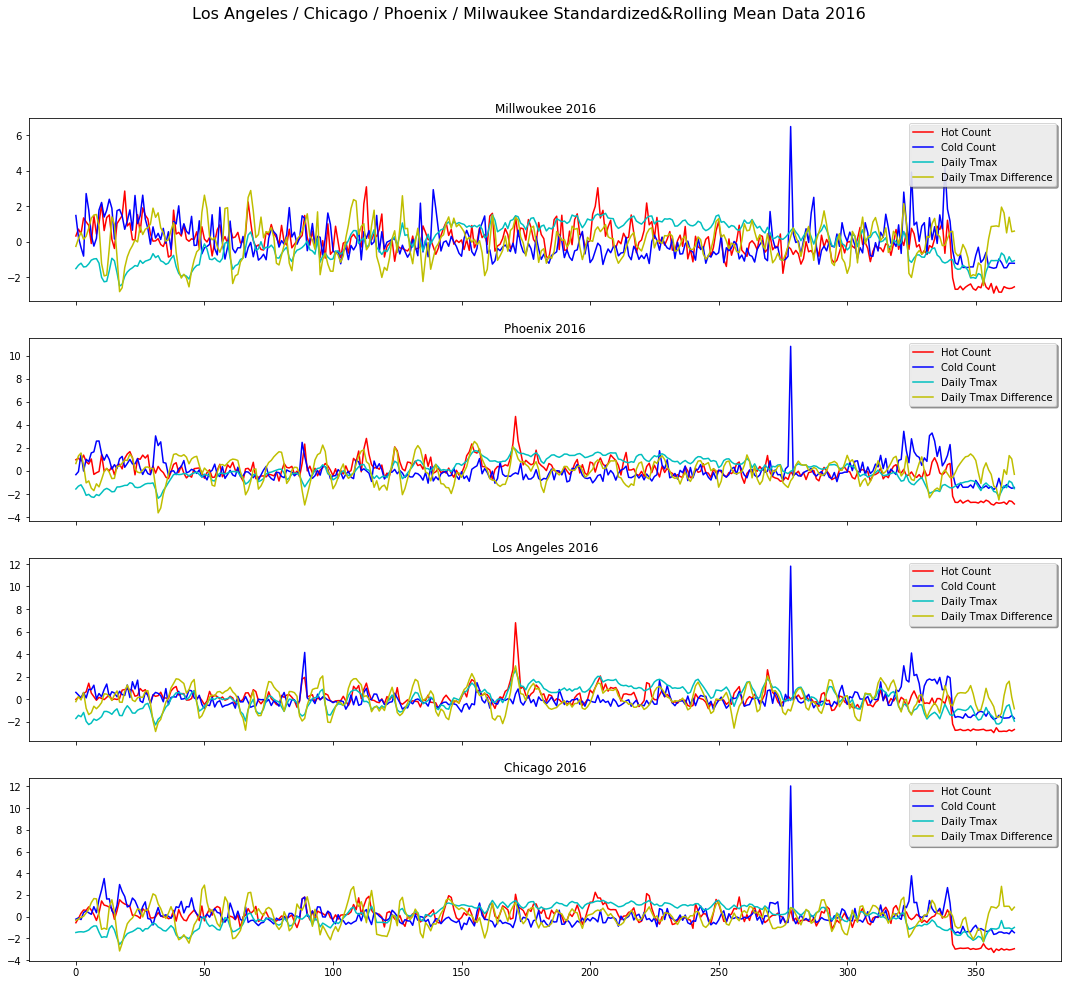

In [24]:
#Stadardize of the three atributes of each city and plot sepeartely 4
f, axarr = plt.subplots(4, sharex=True)
f.suptitle('Los Angeles / Chicago / Phoenix / Milwaukee Standardized&Rolling Mean Data 2016', fontsize=16)
f.set_size_inches(18.5, 15.5, forward=True)
axis=0
for city, measures in sample_cities_dict.iteritems():
    city_st_hot_list= (measures['HOT']- mean(measures['HOT'])) / std(measures['HOT'])
    city_st_cold_list= (measures['COLD']- mean(measures['COLD'])) / std(measures['COLD'])
    city_st_tmax_list= (measures['TMAX']- mean(measures['TMAX'])) / std(measures['TMAX'])
    city_st_tmax_diff_list= (measures['TMAX DIFF']- mean(measures['TMAX DIFF'])) / std(measures['TMAX DIFF'])
    sample_cities_dict[city]['HOT ST']=city_st_hot_list
    sample_cities_dict[city]['COLD ST']=city_st_cold_list
    sample_cities_dict[city]['TMAX ST']=city_st_tmax_list
    sample_cities_dict[city]['TMAX DIFF ST']=city_st_tmax_diff_list
    axarr[axis].plot(x,city_st_hot_list,label='Hot Count', c='r')
    axarr[axis].plot(x,city_st_cold_list,label='Cold Count', c='b')
    #axarr[axis].plot(x,measures['COMB'],label='Word Strength', c='b')
    axarr[axis].plot(x,city_st_tmax_list,label='Daily Tmax', c='c')
    axarr[axis].plot(x,city_st_tmax_diff_list,label='Daily Tmax Difference', c='y')
    axarr[axis].set_title(city+ " 2016")
    legend = axarr[axis].legend(loc='upper right', shadow=True)
    axis=axis+1